# 05 - web scraping and data transformations

1. [The TSA posts passenger numbers](https://www.tsa.gov/coronavirus/passenger-throughput) in a table but there is no download or API option. We can use BeautifulSoup to parse this table.
1. Transform the TSA passenger data in two ways to create two different charts
1. Create two charts inside this notebook with [Matplotlib](https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html)

__Library reference__
- [BeautifulSoup]()
- [pandas]()
- [Matplot for pandas]()
- [Datetime format codes](https://docs.python.org/3/library/datetime.html#strftime-and-strptime-format-codes)

1. Turn the TSA's html table into a dataframe
    1. Create a list of column names
    1. Create a 2d array of data
    1. Format the data into two columns: date and value
1. Transform the data in two different ways for new different charts
1. Create two charts

In [191]:
# !pipenv uninstall matplotlib

In [192]:
#### Import libraries
import pandas as pd
import requests
from bs4 import BeautifulSoup
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# set display format for numbers
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## 1. Turn the TSA's html table into a dataframe

In [193]:
# get html from from page
tsa_r = requests.get('https://www.tsa.gov/coronavirus/passenger-throughput')

In [194]:
# create a beautifulsoup object
tsa_bs = BeautifulSoup(tsa_r.text)

In [195]:
# tsa_bs.text

#### table tag
![table selected](../answers/assets/table.png)

In [197]:
# check pandas docs on read_html
# pandas_tsa = pd.read_html('https://www.tsa.gov/coronavirus/passenger-throughput')

### a. Create a list column names

In [198]:
# turn thead into a column list
thead = tsa_bs.find('thead')

In [199]:
len(thead)

3

In [200]:
# then find all th elements (because there is only 1 row)
ths = thead.find_all('th')

In [201]:
# and loop through each th to extract the text for a list
tsa_col = []
for th in ths:
    tsa_col.append(th.text.strip())

In [202]:
# print the list
tsa_col

['Date',
 '2021 Traveler Throughput',
 '2020 Traveler Throughput',
 '2019 Traveler Throughput']

### b. Create a 2d array of data
![tbody example](../answers/assets/tbody.png)

In [203]:
# turn data into an array of arrays (2d array)
tbody = tsa_bs.find('tbody')

In [204]:
# turn tr tags into a list
trs = tbody.find_all('tr')

In [205]:
# create a list of td tags inside each tr list
tr_list = []
for tr in trs:
    tds = tr.find_all('td')
    td_list = []
    for td in tds:
        td_list.append(td.text.strip())
    tr_list.append(td_list)

In [206]:
# Check the length of the list and the first couple of items
len(tr_list), tr_list[0:2]

(365,
 [['7/13/2021', '1,832,878', '540,268', '2,447,177'],
  ['7/12/2021', '2,093,066', '697,985', '2,615,115']])

### c. Format the data into two columns: date and value

In [207]:
# create a function that will generate dates of preceding years
def format_date(d, column_year):
    date_ = datetime.strptime(d, '%m/%d/%Y')
    year_delta = date_.year - column_year
#     print(year_delta)
    new_date = date_ - timedelta(weeks=year_delta*52)
    return new_date

In [208]:
tsa_col

['Date',
 '2021 Traveler Throughput',
 '2020 Traveler Throughput',
 '2019 Traveler Throughput']

In [209]:
# this double loop can be combined with the loop above that generates tr_list
# but i want to separate text extraction from formatting
passengers_per_day = []
# for each tr
for tr in tr_list:
    # we need to find dates for 2020 and 2019 and align them with the html table format
    # turn string into date object so we can perform datetime calculations on it
    # because the above is a repeatable process, how can move this to a function?
    
    date_list = [format_date(tr[0], 2021),
                 format_date(tr[0], 2020),
                 format_date(tr[0], 2019)]
    
    # for each passenger column td_list[1:]
    for (index, passenger_column) in enumerate(tr[1:]):
        # Create a new dictionary to populate with formatted date
        # index being the column that corresponds to the order of dates in the date_list above
        daily_passengers = {
            'date': date_list[index],
            'value': passenger_column,
        }
#         print(daily_passengers)
        passengers_per_day.append(daily_passengers)
        # if value does exist, change it to an integer (or else there will be an error on missing values)
        
            # add each newly created dictionary to passengers_per_day list

In [210]:
date_2021 = datetime.strptime(tr_list[1][0], '%m/%d/%Y')

In [211]:
date_2021.isoweekday()

1

In [212]:
passengers_per_day[-5:-1]

[{'date': datetime.datetime(2020, 7, 15, 0, 0), 'value': '589,285'},
 {'date': datetime.datetime(2019, 7, 17, 0, 0), 'value': '2,522,563'},
 {'date': datetime.datetime(2021, 7, 13, 0, 0), 'value': ''},
 {'date': datetime.datetime(2020, 7, 14, 0, 0), 'value': '540,268'}]

In [213]:
passengers_per_day[0:5]

[{'date': datetime.datetime(2021, 7, 13, 0, 0), 'value': '1,832,878'},
 {'date': datetime.datetime(2020, 7, 14, 0, 0), 'value': '540,268'},
 {'date': datetime.datetime(2019, 7, 16, 0, 0), 'value': '2,447,177'},
 {'date': datetime.datetime(2021, 7, 12, 0, 0), 'value': '2,093,066'},
 {'date': datetime.datetime(2020, 7, 13, 0, 0), 'value': '697,985'}]

In [214]:
len(tsa_df), len(tsa_df['date'].unique())

(920, 920)

In [215]:
tsa_df[tsa_df['value'] == '']

,date,value


In [216]:
# turn passengers_per_day into a DataFrame with "date" "value" columns
tsa_df = pd.DataFrame(passengers_per_day)

tsa_df = tsa_df[tsa_df['value'] != '']

# sort dates from latest to earliest
tsa_df = tsa_df.sort_values('date', ascending=False)

# delete duplicates
tsa_df = tsa_df.drop_duplicates(subset=['date'])

In [218]:
tsa_df.head(5)

,date,value
0,2021-07-13,"1,832,878"
3,2021-07-12,"2,093,066"
6,2021-07-11,"2,198,635"
9,2021-07-10,"1,987,652"
12,2021-07-09,"2,147,903"


## 2. Transform the data in two different ways for two different charts
[What's moving average and why are they used? - Dallas FED](https://www.dallasfed.org/research/basics/moving.aspx)

### a. Calculate 7-day moving average

In [219]:
# display the last 7 rows
tsa_df[-7:]

,date,value
563,2019-01-10,"2,044,043"
566,2019-01-09,"2,229,391"
569,2019-01-08,"1,975,947"
572,2019-01-07,"2,150,571"
575,2019-01-06,"2,202,111"
578,2019-01-05,"2,345,103"
581,2019-01-04,"2,126,398"


In [220]:
# write a function that takes the current date and 6 previous dates and averages them
def moving_average(row):
    sum_ = 0
    for i in range(0, 7):
        new_date = row['date'] - timedelta(days=i)
        date_value = tsa_df[tsa_df['date'] == new_date]
        value = int(date_value['value'].item().replace(',', ''))
        sum_ = sum_ + value
        
    row['7day_average'] = sum_ / 7
    return row

[Read up on pandas' apply method](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html)

In [95]:
# for row in tsa_df[0:2].iterrows():
#     print(row[1])

In [162]:
# tsa_df[0:-6]

In [221]:
df_average = tsa_df[0:-6].apply(moving_average, axis=1)

In [222]:
df_average = df_average.set_index('date')

In [167]:
# df_average

In [20]:
# calculate 7-day moving average in a new column and start 7 days in (note: result_type apply)
# set the date as the index for matplot

### b. Group data by weeks

In [283]:
# create a function to get day of the first day of the week
def weekday_start(row):
    week_number = row['date'].isocalendar()[1]
#     print(row['date'].isocalendar(), week_number)
    row['year_week'] = str(row['date'].year) + '-' + str(week_number)
    try:
        row['week_start'] = datetime.fromisocalendar(row['date'].year, week_number, 1)
    except:
        if(week_number == 53):
            row['week_start'] = datetime.fromisocalendar(2020, 52, 7) + timedelta(days=1)
        else:
            print(row['week_start'])
    return row

In [282]:
tsa_df.tail(5)

,date,value
569,2019-01-08,"1,975,947"
572,2019-01-07,"2,150,571"
575,2019-01-06,"2,202,111"
578,2019-01-05,"2,345,103"
581,2019-01-04,"2,126,398"


In [284]:
# create a new column that IDs the start date of the week
df_weeks = tsa_df.apply(weekday_start, axis=1)

In [297]:
week_count = pd.DataFrame(df_weeks.groupby('week_start')['week_start'].count())
week_count.columns = ['start']
week_count = week_count.reset_index()

In [300]:
week_count[week_count['week_start'] == '2018-12-31']

,week_start,start
0,2018-12-31,5


In [188]:
df_weeks['value'] = df_weeks['value'].str.replace(',', '').astype(int)

In [189]:
df_by_week = df_weeks.groupby('week_start')['value'].sum()

In [302]:
df_weeks[df_weeks['week_start'] == '2018-12-31']

,date,value,year_week,week_start
590,2019-12-31,"2,009,880",2019-1,2018-12-31
593,2019-12-30,"2,500,396",2019-1,2018-12-31
575,2019-01-06,"2,202,111",2019-1,2018-12-31
578,2019-01-05,"2,345,103",2019-1,2018-12-31
581,2019-01-04,"2,126,398",2019-1,2018-12-31


In [22]:
# groupby week start turn the groupby object into a dataframe

## 3. Create two charts - one for 7-day moving average and one for week totals
Create a bar chart of the daily values for reference

In [25]:
# create a bar chart for daily values

### a. 7-day moving average

<AxesSubplot:xlabel='date'>

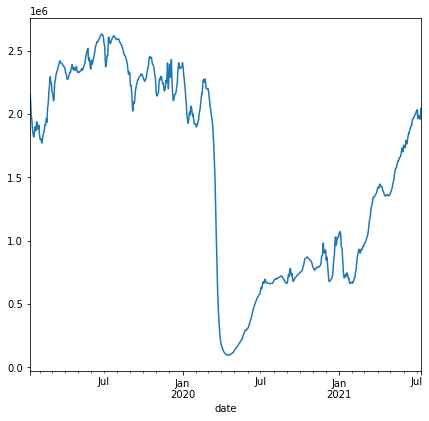

In [170]:
# plot a 7-day average line chart
fig, ax = plt.subplots(1, 1, figsize=(7, 6.5))
df_average['7day_average'].plot(ax=ax)

### b. By weekly totals

In [28]:
# plot as weeks as a line chart